# Wide Residual Network

Definition of WideResNet and Architecture:

Residual Networks vs Wide Residual Networks

##  <center>The Result of Wide Residual Network </center>

***Road Map***
* Data Preprocessing
* Model Cross Validation Results
* Evaluate the GridSearchCV Results
* Model Training and Learning Curves
* Model Adversarial Training Approach.


#### import the libraries.

In [ ]:
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans

print("Cleverhans Version: " + cleverhans.__version__)


In [2]:
import tensorflow as tf
from cleverhans.future.tf2.attacks import fast_gradient_method
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from wresnet import WideResidualNetwork
from adversarial_training import AdversarialTraining
from sklearn.model_selection import  KFold
import gzip
import pickle

import numpy as np

import warnings
warnings.filterwarnings("ignore")

print("\nTensorflow Version: " + tf.__version__)



Tensorflow Version: 2.2.0


<b> Data Preprocessing </b>


* Read Data from File

In [3]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()

* Call data preprocessing function

In [4]:
from preprocessing import preprocessing_data

In [5]:
X, y = preprocessing_data(data)
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size = 0.1)
x_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1)

**Utilize Functions**

* Flipping the image using data augmentation technique

In [6]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

* Print the results of the experiments

In [7]:
def print_test(model,X_adv, X_test, y_test, epsilon):
  loss, acc = model.evaluate(X_adv,y_test)
  print("epsilon: {} and test evaluation : {}, {}".format(epsilon,loss, acc))
  SNR = 20*np.log10(np.linalg.norm(X_test)/np.linalg.norm(X_test-X_adv))
  print("SNR: {}".format(SNR))
  return loss, acc

*  CleverHans Import and Functions Regarding Adversarial Exaples.

In [8]:
def get_adversarial_examples(pretrained_model, X_true, y_true, epsilon):
  #The attack requires the model to ouput the logits
   
  logits_model = tf.keras.Model(pretrained_model.input,pretrained_model.layers[-1].output)
  X_adv = []
  for i in range(len(X_true)):
    random_index = i
    original_image = X_true[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_label = y_true[random_index]
    original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
    adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf,y=original_label, targeted=False)
    X_adv.append(np.array(adv_example_targeted_label).reshape(32,32,1))
  X_adv = np.array(X_adv)
  return X_adv



**Some Parameters Regarding Adversarial Examples**

In [9]:
epsilon_list = [0.003,0.005,0.01,0.02]

**General Visulazation Methods**

* Show accurancy and loss function of the results

In [10]:
import matplotlib.pyplot as plt

def show_graph(hist):
  history = hist
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


## 1.) Baseline of the Model

* Explain the Baseline Model here

Give a shape regarding model base layers

### 1.1. ) Find Model Parameters using Cross Validation and GridSearch 

In [11]:
data_list = []
for  i in range(0,11):
  if i == 5: continue
  data_result  = pd.read_csv("grid_16_{0}.csv".format(str(i)), sep=";")
  data_list.append(data_result)
result = pd.concat(data_list)

#### Evaluate the Results

In [12]:
result["loss_mean"] = (result["loss1"]+result["loss2"]+result["loss3"])/3
result["acc_mean"] = (result["acc1"]+result["acc2"]+result["acc3"])/3

In [13]:
result['epoch'] = result['epoch_stopped1']
result['weight_decay'] = result['reg_penalty']
column_list = ["momentum", "learning rate", "epoch","batch size","weight_decay","loss_mean", "acc_mean"]

In [14]:
result.sort_values(axis=0, by="acc_mean", ascending=False)[column_list].head(3)

,momentum,learning rate,epoch,batch size,weight_decay,loss_mean,acc_mean
0,0.9,0.10,50.0,128.0,0.0001,1.096489,0.726003
3,0.9,0.10,100.0,128.0,0.0010,1.199277,0.722513
0,0.9,0.01,50.0,64.0,0.0010,1.687745,0.718441


In [15]:
result.sort_values(axis=0, by="loss_mean", ascending=True)[column_list].head(3)

,momentum,learning rate,epoch,batch size,weight_decay,loss_mean,acc_mean
2,0.9,0.01,50.0,64.0,0.0100,1.003848,0.708551
3,0.9,0.10,50.0,64.0,0.0010,1.033697,0.699825
2,0.9,0.01,50.0,128.0,0.0001,1.043016,0.689936


Results and comments here

### 1.2.) Train Baseline Model

In [16]:
wresnet_ins = WideResidualNetwork()
EPOCHS = 50
BS = 64
init = (32, 32,1)
sgd = SGD(lr=0.01, momentum=0.9)
#wrn_16_2.summary()
wrn_16_2 = wresnet_ins.create_wide_residual_network(0.0001, 0.01,init,0.9, nb_classes=4, N=2, k=2, dropout=0.0)
wrn_16_2.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")


conv2:channel:  -1
Wide Residual Network-16-2 created.
Finished compiling


In [17]:

hist = wrn_16_2.fit(generator.flow(x_train, y_train, batch_size=BS), steps_per_epoch=len(x_train) // BS, epochs=EPOCHS,
                   validation_data=(X_val, y_val),
                   validation_steps=X_val.shape[0] // BS,)
wrn_16_2.save("wrn_model.h5")

72/72 [==============================] - 2s 30ms/step - loss: 1.1993 - acc: 0.5908 - val_loss: 1.1585 - val_acc: 0.6175
Epoch 14/50
72/72 [==============================] - 2s 31ms/step - loss: 1.1559 - acc: 0.6223 - val_loss: 1.1134 - val_acc: 0.6524
Epoch 15/50
72/72 [==============================] - 2s 31ms/step - loss: 1.1253 - acc: 0.6258 - val_loss: 1.0900 - val_acc: 0.6563
Epoch 16/50
72/72 [==============================] - 2s 31ms/step - loss: 1.0937 - acc: 0.6446 - val_loss: 1.0872 - val_acc: 0.6485
Epoch 17/50
72/72 [==============================] - 2s 31ms/step - loss: 1.0573 - acc: 0.6661 - val_loss: 1.0685 - val_acc: 0.6563
Epoch 18/50
72/72 [==============================] - 2s 31ms/step - loss: 1.0380 - acc: 0.6639 - val_loss: 1.0502 - val_acc: 0.6660
Epoch 19/50
72/72 [==============================] - 2s 31ms/step - loss: 1.0232 - acc: 0.6783 - val_loss: 1.0966 - val_acc: 0.6447
Epoch 20/50
72/72 [==============================] - 2s 31ms/step - loss: 1.0037 - acc: 

In [22]:
wrn_16_2.evaluate(X_test, y_test)

18/18 [==============================] - 0s 5ms/step - loss: 1.0463 - acc: 0.7138


[1.0463284254074097, 0.7137870788574219]

<b>Evaluate the Learning Curve</b>

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


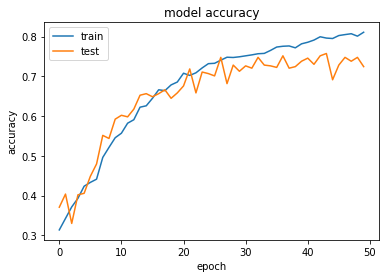

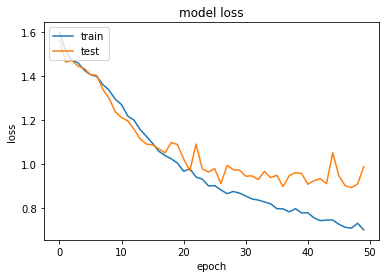

In [19]:
show_graph(hist)

* Evaluate the result

### 1.3.) Adversarial Training on Baseline Model

In [20]:
epsilon_list = [0.003,0.005,0.01,0.02]
EPOCHS = 50
BS = 64
adversarial_training =  AdversarialTraining()
logits_model = tf.keras.Model(wrn_16_2.input, wrn_16_2.layers[-1].output)
sgd = SGD(lr=0.01, momentum=0.9)

In [ ]:
result_adv_df = adversarial_training.train(logits_model, X_train, Y_train, X_test, y_test, EPOCHS, BS, epsilon_list, sgd)

### Evaluate the Results of Adversarial Traing and Non-Adversarial Training 

In [ ]:
result_adv_df["clean_mean"]= np.sum(result_adv_df['acc_clean'])/10.0
result_adv_df["0.003_mean"]= np.sum(result_adv_df['acc1'])/10.0
result_adv_df["0.005_mean"]= np.sum(result_adv_df['acc2'])/10.0
result_adv_df["0.02_mean"]= np.sum(result_adv_df['acc3'])/10.0
result_adv_df["0.01_mean"]= np.sum(result_adv_df['acc4'])/10.0

In [ ]:
column = ["clean_mean","0.003_mean",	"0.005_mean",	"0.02_mean",	"0.01_mean"]
result_adv_df[column].head(1)

,clean_mean,0.003_mean,0.005_mean,0.02_mean,0.01_mean
0,0.752007,0.744677,0.739965,0.726702,0.697033


## 2. Complex Model

### 2.1.) Find Model Parameters using Cross Validation and GridSearch

### 2.2.) Train Model

### 2.3.) Adversarial Training

#### <center> Evaluate the Results of Adversarial Traing and Non-Adversarial Training for the Model</center>